# Classification after Clustering with K-means

### Import CSV and Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import SelectByShuffling
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

# Hyperparameter tuning (hyperopt)
from hyperopt import tpe,hp,Trials,space_eval
from hyperopt.fmin import fmin
from hyperopt.pyll import scope



warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv(r"./data/clustered_data.csv")
# Print shape of dataset
print(df.shape)

(8950, 18)


## Feature Selection

- **SelectByShuffling()** selects features by determining the drop in machine learning model performance when each feature’s values are randomly shuffled.

- If the variables are important, a random permutation of their values will decrease dramatically the machine learning model performance. Contrarily, the permutation of the values should have little to no effect on the model performance metric we are assessing.

- The **SelectByShuffling()** first trains a machine learning model utilising all features. Next, it shuffles the values of 1 feature, obtains a prediction with the pre-trained model, and determines the performance drop (if any). If the drop in performance is bigger than a threshold then the feature is retained, otherwise removed. It continues until all features have been shuffled and the drop in performance evaluated.

- The user can determine the model for which performance drop after feature shuffling should be assessed. The user also determines the threshold in performance under which a feature will be removed, and the performance metric to evaluate.

**Split X and y**

In [2]:
X = df.drop("cluster", axis=1)
y = df["cluster"]

**Define RandomForestClassifier model**

In [3]:
rf = RandomForestClassifier(random_state=42)

**Why Threshold is None**? 
* If None, the selector will select features which performance drift is smaller than the mean performance drift across all features.

**Select by Shuffling is used as feature selector**

In [4]:
shuf = SelectByShuffling(
    estimator=rf, # the model
    scoring='accuracy', # the metric to evaluate
    threshold=0.01, #1% is kept as max performance drift
    cv=3,
    random_state=1
)

Xt = shuf.fit_transform(X, y)

**Initial model Performance**

In [5]:
shuf.initial_model_performance_

0.954972015984532

### **Performance Drift**

In [6]:
pd.DataFrame.from_dict(shuf.performance_drifts_, orient='index').sort_values(0, ascending=False)

,0
BALANCE,0.042122
PURCHASES_TRX,0.034191
PURCHASES,0.031286
MINIMUM_PAYMENTS,0.024022
PURCHASES_FREQUENCY,0.018436
ONEOFF_PURCHASES,0.014078
CASH_ADVANCE,0.013966
ONEOFF_PURCHASES_FREQUENCY,0.012180
PAYMENTS,0.011509
INSTALLMENTS_PURCHASES,0.011173


**Plotting the performance drift**

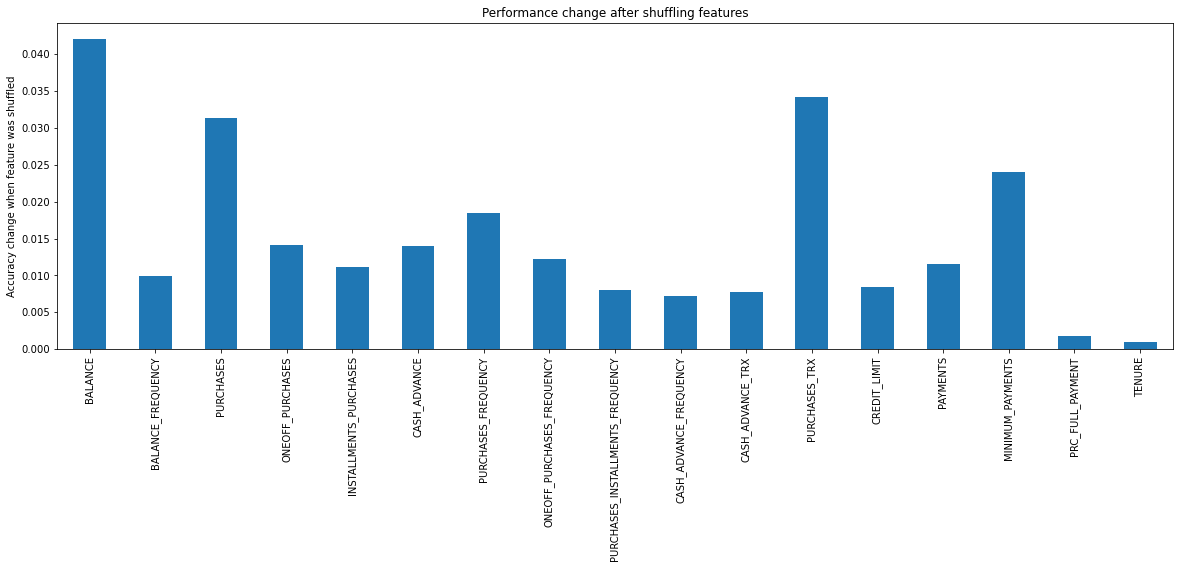

In [7]:
# Changes in performance after shuffling each feature

pd.Series(shuf.performance_drifts_).plot.bar(figsize=(20,6))
plt.title('Performance change after shuffling features')
plt.ylabel('Accuracy change when feature was shuffled')
plt.show()

**Features which come under 1% performance drift**

In [8]:
shuf.features_to_drop_

['BALANCE_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'CREDIT_LIMIT',
 'PRC_FULL_PAYMENT',
 'TENURE']

**X after dropping less important features**

In [22]:
Xt.head()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS
0,40.900749,95.40,0.0000,95.4,0.000000,0.166667,0.000000,2,201.802084,139.509787
1,3202.467416,0.00,0.0000,0.0,2784.552848,0.000000,0.000000,0,4103.032597,1072.340217
2,2495.148862,773.17,773.1700,0.0,0.000000,1.000000,0.750000,12,622.066742,627.284787
3,1666.670542,1499.00,1443.5125,0.0,205.788017,0.083333,0.083333,1,0.000000,312.343947
4,817.714335,16.00,16.0000,0.0,0.000000,0.083333,0.083333,1,678.334763,244.791237


## Hyperopt: Distributed Hyperparameter Optimization

- Hyperopt is a powerful python library for hyperparameter optimization developed by James Bergstra. Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model.
- Grid Search is exhaustive in case of Resources usage.
- Random Search, is random, so could miss the most important values. However, there is a superior method available through the Hyperopt package.

### Search space is where Hyperopt really gives you a many of sampling options

In [12]:
def rf_objective(params):
    model=RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    acc = cross_val_score(model, Xt, y, scoring="accuracy").mean()
    return -acc

In [13]:
# Define the paramters for rf in search_space
params={'n_estimators':hp.randint('n_estimators',100,500),
        'max_depth':hp.randint('max_depth',5,40),
        'min_samples_leaf':hp.randint('min_samples_leaf',2,10),
        'min_samples_split':hp.randint('min_samples_split',2,10),
        'criterion':hp.choice('criterion',['gini','entropy']),    
        'max_features':hp.choice('max_features',['sqrt', 'log2']),
       }

rf_trials = Trials()

# Using Fmin function to get best rf_objective
best_rf= fmin(
    fn=rf_objective,
    space=params,
    algo=tpe.suggest,
    trials=rf_trials,
    max_evals=100,
    rstate=np.random.default_rng()
)

100%|█████████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/trial, best loss: -0.9451396648044692]


### Why Feature selection and its effect on performance
**Sometimes features selection also results in the loss of predictive accuracy, here we lost 1% overall accuracy from initial model.**

- 18 features = 95.4% accuracy
- 10 features = 94.5% accuracy

- However, if you see the difference between those 2 results, you can roughly say that you removed 8 less significant features from a total of 18 features and achieved a 94.5% accuracy. That's good right? Why?

- Generally, the underlying principle here is that the features selection able to reduce the dimensionality of the predictive models. The dimensionality depends on the dimensions of the data. Linear (2D), more than that its n-dimensions. So, while the dimensionality of the model decreases, the complexity of the model also decreases. This eventually leads to a faster model training time and convergence.

- With enough justification on the approach, Its good with -3% of predictive accuracy while we can greatly reduces the model complexity, training time and overfitting while increasing the generalization ability.

#### Visualization of Hyperparameter tuning

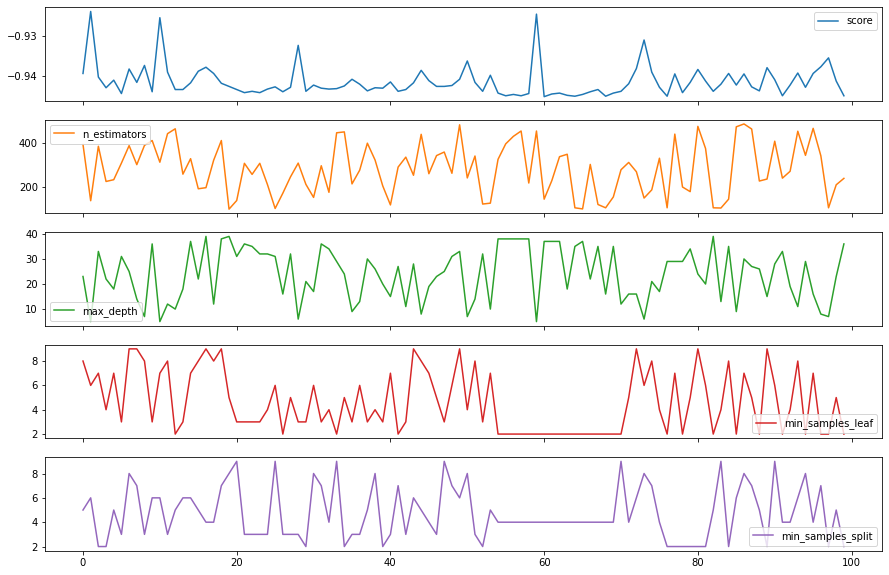

In [14]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_samples_leaf'][0],
                      x['misc']['vals']['min_samples_split'][0]] for x in rf_trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score','n_estimators', 'max_depth', 'min_samples_leaf', 'min_samples_split'])
tpe_results_df.plot(subplots=True,figsize=(15, 10))
plt.show()

**Best Parameters**

In [15]:
best_rf

{'criterion': 0,
 'max_depth': 37,
 'max_features': 0,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 146}

### Split into Train and test data

In [10]:
# Separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xt, y, random_state=42, test_size=0.3)

X_train

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS
5831,649.896506,2715.8725,1443.5125,566.70000,191.376535,0.916667,0.666667,41,4177.921543,219.441278
2244,2382.328208,899.5800,413.2800,486.30000,450.252732,1.000000,0.250000,34,850.186851,1212.047288
4205,1119.157048,133.9000,133.9000,0.00000,269.234406,0.166667,0.166667,3,427.355150,320.855529
7933,0.000000,136.8000,0.0000,136.80000,0.000000,1.000000,0.000000,12,127.996550,312.343947
8462,20.620429,169.6600,0.0000,169.66000,0.000000,0.750000,0.000000,9,192.185764,145.811693
...,...,...,...,...,...,...,...,...,...,...
5734,1079.097023,247.4400,0.0000,247.44000,0.000000,1.000000,0.000000,12,503.445403,302.481716
5191,833.541256,0.0000,0.0000,0.00000,1422.637361,0.000000,0.000000,0,180.104404,282.085369
5390,40.247238,0.0000,0.0000,0.00000,909.480894,0.000000,0.000000,0,3578.648701,69.271137
860,0.000000,199.8800,0.0000,199.88000,0.000000,0.750000,0.000000,14,0.000000,312.343947


**Initialize model with best parameters**

In [11]:
rf= RandomForestClassifier(criterion='gini',
                           max_depth=37, 
                           max_features='sqrt', 
                           min_samples_leaf=2, 
                           min_samples_split=4, 
                           n_estimators= 146
                          )

**Model Report**

In [12]:
best_model = rf.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("Random Forest Classifier")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

Random Forest Classifier
Accuracy Score value: 0.9426
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       738
           1       0.93      0.94      0.94       818
           2       0.92      0.91      0.92       619
           3       0.93      0.94      0.93       510

    accuracy                           0.94      2685
   macro avg       0.94      0.94      0.94      2685
weighted avg       0.94      0.94      0.94      2685



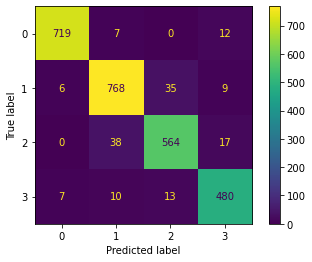

In [13]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

### Visualize tree

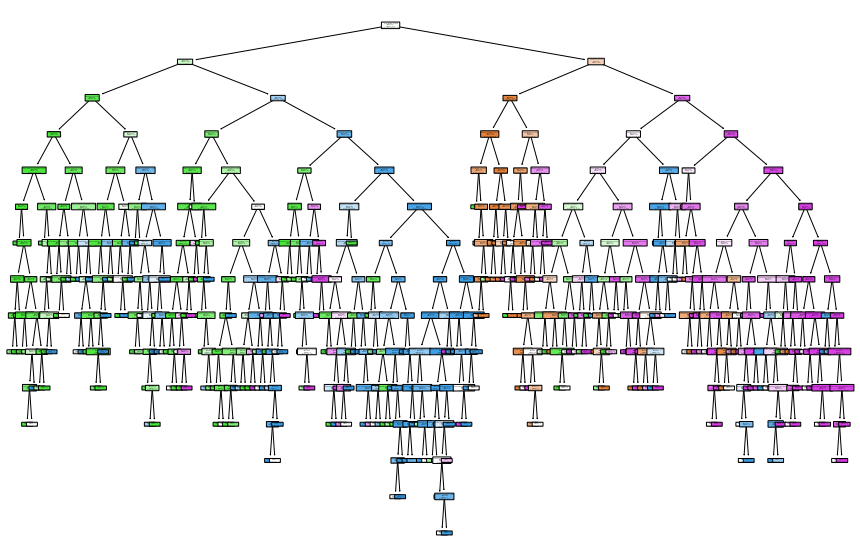

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(15, 10))
plot_tree(best_model.estimators_[0], 
          feature_names=Xt.columns,
          filled=True, impurity=True, 
          rounded=True)
plt.show()

In [ ]:
##############################################################################################################################